# CEE 598: Uncertainty Quantification
## Assignment Three
### Noah Garfinkle (garfink2@illinois edu)
### 03 March 2020

## Imports and Setup

In [101]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import pandas as pd

## Problem One

Similar to importance sampling example in lecture notes, we would lke now to calculate $\theta = P(X>2)$ where $X$ is distributed according to the standard Cauchy PDF, given by

$$
f_X(x) = \frac{1}{\pi(1+x^2)}
$$

Consider the proposal to be $q_x(x) = \frac{2}{x^2}$ defined over the domain of interest.  Write a Monte Carlo (MC) integration code, as well as importance sampling code for the estimation of $\theta$.  The input to these codes should be the size of the sample set $n$.  Let $\hat{\theta_f}$ be the result obtained from standard MC method and $\hat{\theta_g}$ be that from importance sampling.

### (a) Compare the convergence behaviors for $\hat{\theta_f}$ and $\hat{\theta_g}$.

In [121]:
def f(x):
    fx = 1 / (np.pi*(1+np.power(x,2)))
    return fx

In [122]:
def q(x):
    qx = 2 / np.power(x,2)
    return qx

Plot to compare the distributions

In [123]:
xs = np.linspace(1.9,10,200)
fs = [f(x) for x in xs]
qs = [q(x) for x in xs]

Text(0, 0.5, '$P(X==x)$')

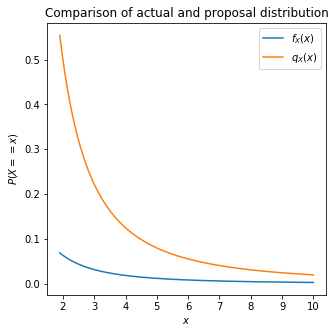

In [124]:
fig,ax = plt.subplots(figsize=(5,5))
sns.lineplot(xs,fs,label="$f_X(x)$",ax=ax)
sns.lineplot(xs,qs,label="$q_X(x)$",ax=ax)
ax.set_title("Comparison of actual and proposal distribution")
ax.set_xlabel("$x$")
ax.set_ylabel("$P(X==x)$")

In [163]:
stats.cauchy.cdf(10)-stats.cauchy.cdf(2)

0.11585810021987974

#### Monte Carlo Integration

Approach:

Let us assume that the maximum value of the distirbution, per the figure above, is 0.1.  Therefore, we will randomly select values on the x axis between 2 and a very large number (or a number with a very small probability along the tail, perhaps even as low as 10), and between 0 and 0.1.  We will check whether they fall under the curve.

In [283]:
n = 10000
min_x = 2.0
max_x = 20
min_y = 0.0
max_y = 0.1
sample_xs = []
sample_ys = []
p_xs = []
sample_hits = []
for i in range(0,n):
    sample_x = np.random.random() * max_x
    sample_y = np.random.random() * max_y
    p_x = f(sample_x)
    if sample_y < p_x:
        sample_hits.append(True)
    else:
        sample_hits.append(False)
    sample_xs.append(sample_x)
    sample_ys.append(sample_y)
    p_xs.append(p_x)
df = pd.DataFrame({"x":sample_xs,"y":sample_ys,"f(x)":p_xs,"hit":sample_hits})

In [284]:
df.head()

,x,y,f(x),hit
0,7.188179,0.061246,0.006043,False
1,19.173905,0.011777,0.000863,False
2,18.367499,0.026630,0.000941,False
3,14.151795,0.027807,0.001581,False
4,17.298040,0.015501,0.001060,False


In [285]:
area_rectangle = (max_x-min_x) * (max_y-min_y)
nHits = len(df[(df["hit"]==True) & (df["x"]>2)])
fractionHits = nHits / n
fractionArea = fractionHits * area_rectangle

In [286]:
fractionArea

0.11952

Text(0.5, 1.0, 'Monte Carlo approach to area estimation with 10000 samples\n$P(x>2)=0.12$')

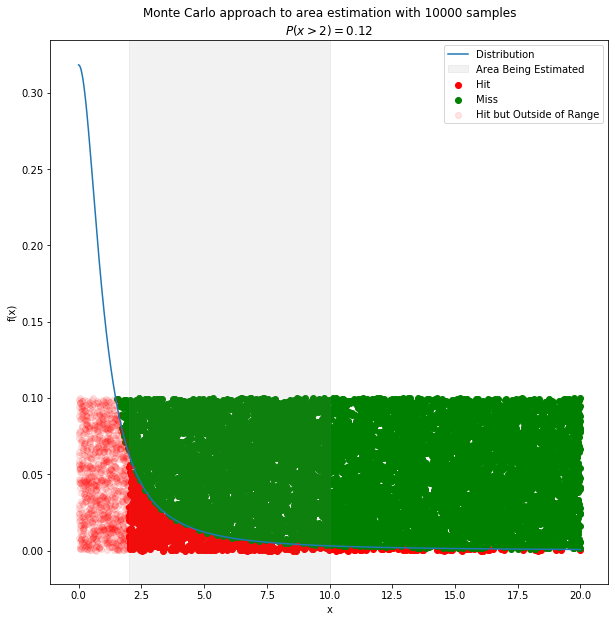

In [287]:
fig,ax = plt.subplots(figsize=(10,10))
df_Miss = df[df["hit"]==False]
df_hitAbove2 = df[(df["hit"]==True) & (df["x"]>2)]
df_hitBelow2 = df[(df["hit"]==True) & (df["x"]<=2)]
ax.scatter(x=df_hitAbove2["x"],y=df_hitAbove2["y"],color="red",label="Hit")
ax.scatter(x=df_Miss["x"],y=df_Miss["y"],color="green",label="Miss")
ax.scatter(x=df_hitBelow2["x"],y=df_hitBelow2["y"],color="red",label="Hit but Outside of Range",alpha=0.1)
ax.axvspan(2,10,alpha=0.1,color="grey",label="Area Being Estimated")
sns.lineplot(x="x",y="f(x)",data=df,ax=ax,label="Distribution")
ax.set_title(f"Monte Carlo approach to area estimation with {n} samples\n$P(x>2)={fractionArea:,.2f}$")

#### Importance Sampling

#### Discussion

### (b) At each sample number, use the previous samples to calculate the sample variance for the $\theta$ estimates, i.e. $Var(\hat{\theta_f})$ and $Var(\hat{\theta_g})$.  Compare these two measures and their convergences.

### (c) Discuss your observations

## Problem Two

Write a Metropolis-Hastings code that can be used to draw samples from the Rayleigh PDF given by

$$
f(x;\sigma)=\frac{x}{\sigma^2}e^{\frac{-x^2}{2\sigma^2}}, x\geq0
$$

Choose the proposal to be $q(y|x)=N(x,\sigma_q^2)$

In [79]:
def f_rayleigh(x,σ):
    p = x / np.power(σ,2)*np.exp(-np.power(x,2)/(2*np.power(σ,2)))
    return p

First, we begin by ensuring that our impelmented distribution matches an accepted distribution.

In [90]:
xs = np.linspace(0,10,100)
fs_rayleigh = [f_rayleigh(x,1) for x in xs]
pdf_rayleigh = [stats.rayleigh.pdf(x,scale=1) for x in xs]

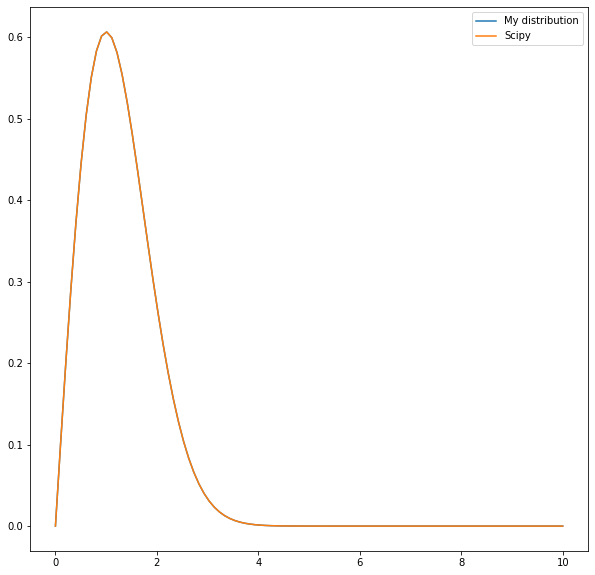

In [91]:
fig,ax = plt.subplots(figsize=(10,10))
sns.lineplot(xs,fs_rayleigh,label="My distribution",ax=ax)
sns.lineplot(xs,pdf_rayleigh,label="Scipy",ax=ax)

### (a) Assume $\sigma = \sigma_q = 1$.  We have two ways to implement the algorithm now that the supports of $f$ and $q$ are different:

_Option a.1_: We draw samples from the proposal distribution, and only if they fall inside the domain interest, we consider them a candidate, based on which we evaluate the rejection probability and move to the acceptance/rejection step.  That is, if they don't fall inside the support of $f$ we don't make a self-transition, and just free the step timer, until a proposal falls inside the support.

_Option a.2_: We draw samples from the proposal distribution, and no matter where they fall (inside or outside the domain of interest), we treat them as a candidate, based on which we evaluate the rejection probability and move to the acceptance/rejection step.  That is, no matter where the proposal draw is, we will not freeze the time stepper.

Compare the two sample populations generated using these two codes with the target distribution and commennt on the options you would pick.

### (b) Assume $\sigma = 1$ in the target Rayleigh distribution.  Determine what choice of $\sigma_q$ will lead to a better sampling algorithm.  Include details about your thought process and numerical tests in reaching a good proposal.

### (c) Write an adaptive Metropolis algoirthm to sample from the target Rayleigh distribution with $\sigma = 1$.  Choose your own parameters